# FESDModel

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path
from time import time

from data import FESDDataset
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import cv2

from model import FESD, train, val, test
import copy

import scipy

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import datetime

from utils import AvgMeter, clip_gradient, get_scheduler
from utils.mode import Mode
from utils import err2gt, gt2err

from copy import deepcopy

from tqdm.notebook import tqdm

num_gpus = torch.cuda.device_count()
is_cuda = torch.cuda.is_available()
print(f"Num cuda GPUs: {num_gpus}")
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [ ]:
RECORDING_DIR = Path('H:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Data Loading

Firstly we need to import all the recordings into the notebook.


In [ ]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

In [ ]:
batchsize = 10
train_size = 300

dataset_train = FESDDataset(RECORDING_DIR, train_size)
dataset_train.randomize_augmentation_params = True

dataset_test = FESDDataset(RECORDING_DIR, train_size, test=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

print(len(train_loader))
print(len(test_loader))

In [ ]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
limbs = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]
lower_body_i = [14, 15, 16, 17, 18, 19]

torso_i = [2, 3, 4]
head_i = [0, 1]
left_arm_i = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

In [ ]:
i = 500
mode = Mode.FULL_BODY
dataset_train.mode = mode
rgb, depth, pose_2d, gt, session = dataset_train[i]
dataset_train.frame.show()
print(gt)
print(gt2err(gt, mode))
if mode == Mode.HALF_BODY:
  print(body_halves[np.nonzero(gt2err(gt, mode)[0].tolist())])
elif mode == Mode.LIMBS:
  print(limbs[np.nonzero(gt2err(gt, mode)[0].tolist())])

## Data Analysis

Now that the data is loaded we can analyse it

In [ ]:
cols = ['Type', 'Session', 'Difficulty', 'Exercise', 'Frame', 'Joint', 'Error', 'mode']
df_data = pd.DataFrame(columns=cols)

for i in tqdm(range(len(dataset_train))):
  for m in [Mode.FULL_BODY, Mode.HALF_BODY, Mode.LIMBS, Mode.JOINTS]:
    dataset_train.mode = m
    rgb, depth, pose_2d, gt, session = dataset_train[i]
    
    gt = gt2err(gt, m)[0]
    session, frame_i = dataset_train.get_index(i)
    frame = dataset_train.frame
    session_name = frame.session["Name"]
    exercise = frame.session['Session Parameters']['Exercise']
    difficulty = int(exercise[2])

    for j in range(len(gt)):
      row = ["Train", session_name, difficulty, exercise, frame_i, j, gt.tolist()[j], m]
      df_data.loc[len(df_data)] = row

for i in tqdm(range(len(dataset_test))):
  for m in [Mode.FULL_BODY, Mode.HALF_BODY, Mode.LIMBS, Mode.JOINTS]:
    dataset_test.mode = m
    _, _, _, gt, _ = dataset_test[i]
    gt = gt2err(gt, m)[0]
    session, frame_i = dataset_test.get_index(i)
    frame = dataset_test.frame
    session_name = frame.session["Name"]
    exercise = frame.session['Session Parameters']['Exercise']
    difficulty = int(exercise[2])

    for j in range(len(gt)):
      row = ["Test", session_name, difficulty, exercise, frame_i, j, gt.tolist()[j], m]
      df_data.loc[len(df_data)] = row
  
dataset_train.mode = mode
dataset_test.mode = mode
df_data

In [ ]:
df_data_joints = df_data[df_data['mode'] == Mode.JOINTS]
df_data_limbs = df_data[df_data['mode'] == Mode.LIMBS]
df_data_half_body = df_data[df_data['mode'] == Mode.HALF_BODY]
df_data_full_body = df_data[df_data['mode'] == Mode.FULL_BODY]

### Error Distribution Per Joint

Here we investigate the distribution of errors based on Body regions

In [ ]:
df_data_joints["pose_id"] = df_data_joints["Session"] + "_" + df_data_joints["Frame"].astype(str)

In [ ]:
df_data_joints["Upper Body"] = df_data_joints["Joint"].apply(lambda x: x in upper_body_i)
df_data_joints["Lower Body"] = df_data_joints["Joint"].apply(lambda x: x in lower_body_i)

df_data_joints["Torso"] = df_data_joints["Joint"].apply(lambda x: x in torso_i)
df_data_joints["Head"] = df_data_joints["Joint"].apply(lambda x: x in head_i)
df_data_joints["Left Arm"] = df_data_joints["Joint"].apply(lambda x: x in left_arm_i)
df_data_joints["Right Arm"] = df_data_joints["Joint"].apply(lambda x: x in right_arm_i)
df_data_joints["Left Leg"] = df_data_joints["Joint"].apply(lambda x: x in left_leg_i)
df_data_joints["Right Leg"] = df_data_joints["Joint"].apply(lambda x: x in right_leg_i)

In [ ]:
df_data_joints["body_half"] = df_data_joints["Joint"].apply(lambda x: "Upper Body" if x in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13] else "Lower Body")
df_data_joints["body_part"] = df_data_joints["Joint"].apply(lambda x: "Left Arm" if x in [5, 6, 7, 8] else "Right Arm" if x in [10, 11, 12, 13] else "Left Leg" if x in [14, 15, 16] else "Right Leg" if x in [27, 28, 19] else "Torso" if x in [2, 3, 4, 9] else "Head" if x in [0, 1] else "None")

In [ ]:
df_data_joints["error_simple"] = df_data_joints["Error"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
error_distr = df_data_joints.groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
error_distr.plot.hist(bins = 20, density=True, alpha = 0.7)
error_distr.plot(kind = "kde", alpha = 0.7)
quant = error_distr.quantile(0.8)
ax.axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")
ax.set_title("Distribution of number of joints with error per pose")
ax.set_xlabel("Number of Joints with Error")
ax.set_ylabel("Number of poses")
ax.set_xlim(0, 20)
ax.set_xticks(range(0, 21, 5))
ax.set_yticks([])
plt.savefig("figures/distribution_of_joint_errors_per_pose.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize = (6,8), nrows=2, ncols=1)

err_dist_upper = df_data_joints[df_data_joints["body_half"] == "Upper Body"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_lower = df_data_joints[df_data_joints["body_half"] == "Lower Body"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]

err_dist_upper.plot.hist(bins = range(16), density=True, ax = axs[0])
err_dist_upper.plot(kind = "kde", ax = axs[0])

err_dist_lower.plot.hist(bins = range(11), density=True, ax = axs[1])
err_dist_lower.plot(kind = "kde", ax = axs[1])

fig.suptitle("Distribution of number of joints with error per pose per body half")
axs[0].set_title("Upper Body")
axs[1].set_title("Lower Body")

axs[0].set_xlim(0, 15)
axs[0].set_xticks(range(0, 16, 5))
axs[1].set_xlim(0, 10)
axs[1].set_xticks(range(0, 11, 5))

quant = err_dist_upper.quantile(0.8)
axs[0].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_lower.quantile(0.8)
axs[1].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

axs[1].set_xlabel("Number of Joints with Error")
for ax in axs:
  ax.set_ylabel("Number of poses")
  ax.set_yticks([])

plt.savefig("figures/distribution_of_joint_errors_per_pose_per_body_half.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize = (6,8), nrows=3, ncols=2)

err_dist_torso = df_data_joints[df_data_joints["body_part"] == "Torso"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_head = df_data_joints[df_data_joints["body_part"] == "Head"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_left_arm = df_data_joints[df_data_joints["body_part"] == "Left Arm"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_right_arm = df_data_joints[df_data_joints["body_part"] == "Right Arm"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_left_leg = df_data_joints[df_data_joints["body_part"] == "Left Leg"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]
err_dist_right_leg = df_data_joints[df_data_joints["body_part"] == "Right Leg"].groupby("pose_id")["error_simple"].sum().reset_index()["error_simple"]

err_dist_torso.plot.hist(bins = range(6), density=True, ax = axs[0][0])
err_dist_torso.plot(kind = "kde", ax = axs[0][0])

err_dist_head.plot.hist(bins = range(6), density=True, ax = axs[0][1])
err_dist_head.plot(kind = "kde", ax = axs[0][1])

err_dist_left_arm.plot.hist(bins = range(6), density=True, ax = axs[1][0])
err_dist_left_arm.plot(kind = "kde", ax = axs[1][0])

err_dist_right_arm.plot.hist(bins = range(6), density=True, ax = axs[1][1])
err_dist_right_arm.plot(kind = "kde", ax = axs[1][1])

err_dist_left_leg.plot.hist(bins = range(6), density=True, ax = axs[2][0])
err_dist_left_leg.plot(kind = "kde", ax = axs[2][0])

err_dist_right_leg.plot.hist(bins = range(6), density=True, ax = axs[2][1])
err_dist_right_leg.plot(kind = "kde", ax = axs[2][1])

fig.suptitle("Distribution of number of joints with error per pose per body part")

axs[0][0].set_title("Torso")
axs[0][1].set_title("Head")
axs[1][0].set_title("Left Arm")
axs[1][1].set_title("Right Arm")
axs[2][0].set_title("Left Leg")
axs[2][1].set_title("Right Leg")

axs[2][0].set_xlabel("Number of Joints with Error")
axs[2][1].set_xlabel("Number of Joints with Error")

quant = err_dist_torso.quantile(0.8)
axs[0][0].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_head.quantile(0.8)
axs[0][1].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_left_arm.quantile(0.8)
axs[1][0].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_right_arm.quantile(0.8)
axs[1][1].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_left_leg.quantile(0.8)
axs[2][0].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

quant = err_dist_right_leg.quantile(0.8)
axs[2][1].axvline(quant, color="red", alpha = .7, ymax = 1, linestyle = ":")

for ax in axs:
  ax[0].set_ylabel("Number of poses")
  ax[1].set_ylabel("")
  for a in ax:
    a.set_xlim(0, 5)
    a.set_xticks(range(0, 6, 1))
    a.set_yticks([])

plt.tight_layout()
plt.savefig("figures/distribution_of_joint_errors_per_pose_per_body_part.png")
plt.show()

### Error Distribution

Here we investigate the distribution of errors over the dataset for different body regions

#### Joints

In [218]:
df_data_joints["Joint Name"] = df_data_joints["Joint"].apply(lambda x: joint_names[x])
df_data_joints["Simple Error"] = df_data_joints["Error"] != 0
df_data_joints["Difficulty Name"] = df_data_joints["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_joints

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\897122408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_joints["Joint Name"] = df_data_joints["Joint"].apply(lambda x: joint_names[x])
C:\Users\leona\AppData\Local\Temp\ipykernel_24772\897122408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_joints["Simple Error"] = df_data_joints["Error"] != 0
C:\Users\leona\AppData\Local\Temp\ipykernel_24772\897122408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Simple Error,Difficulty Name
9,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0.0,Mode.JOINTS,Head,False,Trivial
10,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0.0,Mode.JOINTS,Neck,False,Trivial
11,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,2,0.0,Mode.JOINTS,Torso,False,Trivial
12,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,3,0.0,Mode.JOINTS,Waist,False,Trivial
13,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,4,0.0,Mode.JOINTS,Left collar,False,Trivial
...,...,...,...,...,...,...,...,...,...,...,...
22615,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,15,0.0,Mode.JOINTS,Left knee,False,Hard
22616,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,16,1.0,Mode.JOINTS,Left ankle,True,Hard
22617,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,17,0.0,Mode.JOINTS,Right hip,False,Hard
22618,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,18,0.0,Mode.JOINTS,Right knee,False,Hard


[]

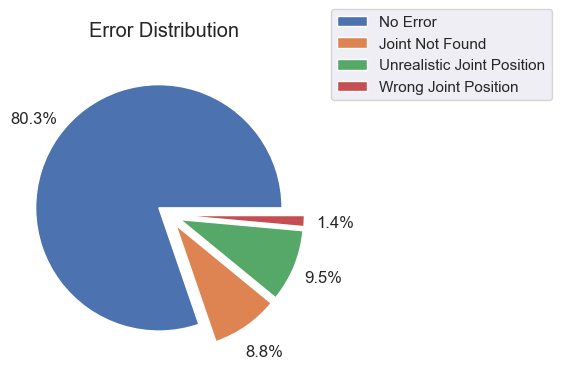

In [221]:
ax = df_data_joints[["Error", "Frame"]].groupby("Error").count().plot.pie(subplots=True, figsize=(4, 4), title="Error Distribution", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), labeldistance=None)

ax[0].set_ylabel("")
ax[0].legend(bbox_to_anchor=(1, 1.02), loc='center left')

plt.savefig("figures/dist_joints/Error_Distribution.png")
plt.plot()

<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

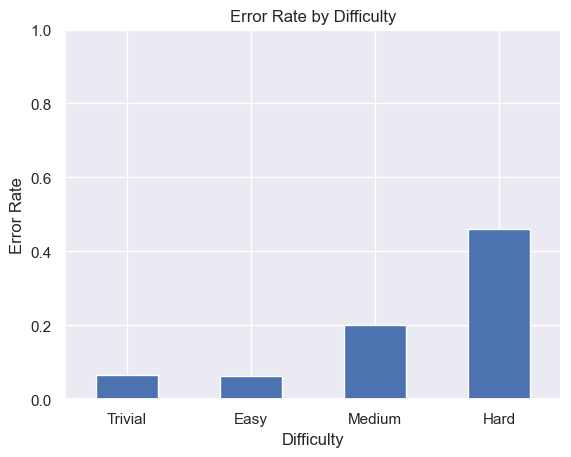

In [222]:
error_by_difficulty = df_data_joints[['Difficulty', "Difficulty Name", "Simple Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Simple Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_joints/Error_Rate_by_Difficulty.png")
ax

[]

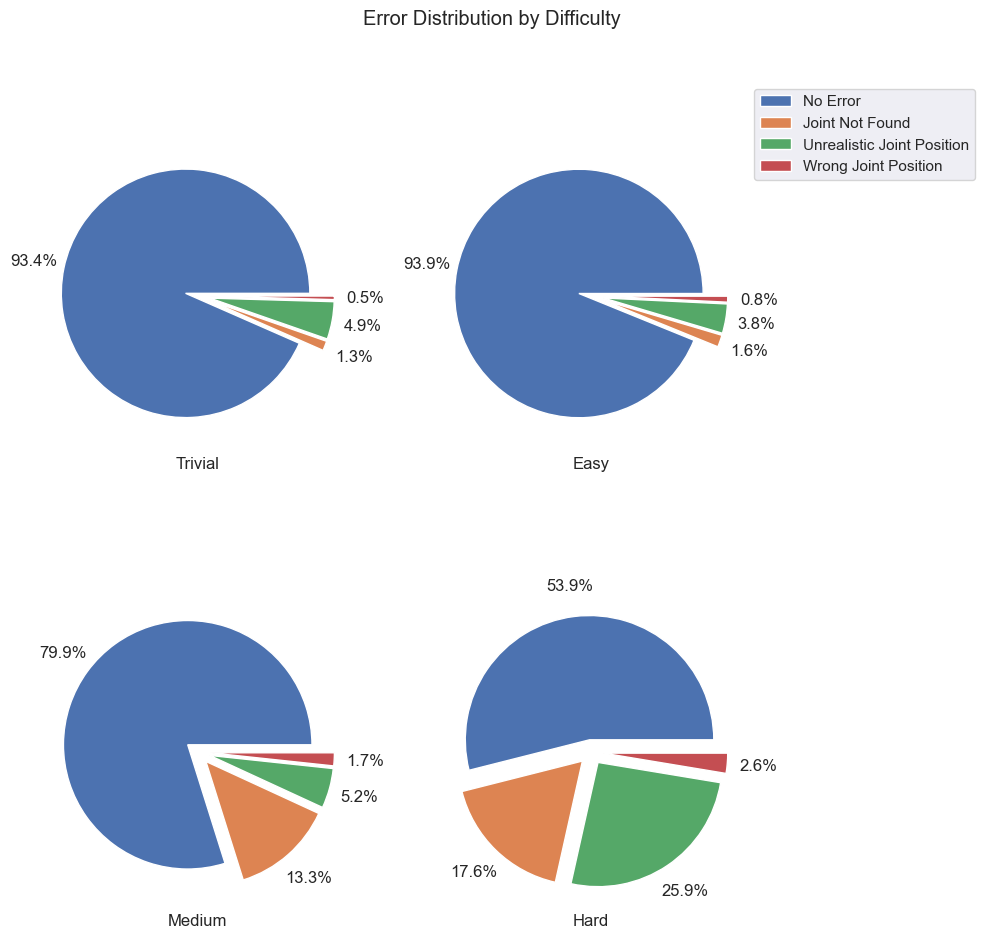

In [223]:
err_group = df_data_joints[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name", "Error"]).count()["Difficulty"].unstack().T
error_distribution_by_difficulty = (err_group / err_group.sum()).T
error_distribution_by_difficulty['sort_key'] = pd.CategoricalIndex(error_distribution_by_difficulty, [3, 0, 2, 1])
error_distribution_by_difficulty.sort_values('sort_key', inplace=True)
error_distribution_by_difficulty.drop('sort_key', axis=1, inplace=True)

axs = error_distribution_by_difficulty.T.plot.pie(subplots=True, figsize=(10, 10), layout=(2, 2), legend=False, title="Error Distribution by Difficulty", labels=joint_errors, autopct='%1.1f%%', pctdistance=1.25, fontsize=12, explode=(.1,.1,.1,.1), sharex=False, sharey=False, labeldistance=None)

axs[0, 0].set_xlabel("Trivial")
axs[0, 0].set_ylabel("")
axs[0, 1].set_xlabel("Easy")
axs[0, 1].set_ylabel("")
axs[0, 1].legend(bbox_to_anchor=(1, 1.02), loc='center left')
axs[1, 0].set_xlabel("Medium")
axs[1, 0].set_ylabel("")
axs[1, 1].set_xlabel("Hard")
axs[1, 1].set_ylabel("")

plt.tight_layout()
plt.savefig("figures/dist_joints/Error_Distribution_by_Difficulty.png")
plt.plot()

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\890484243.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))


[]

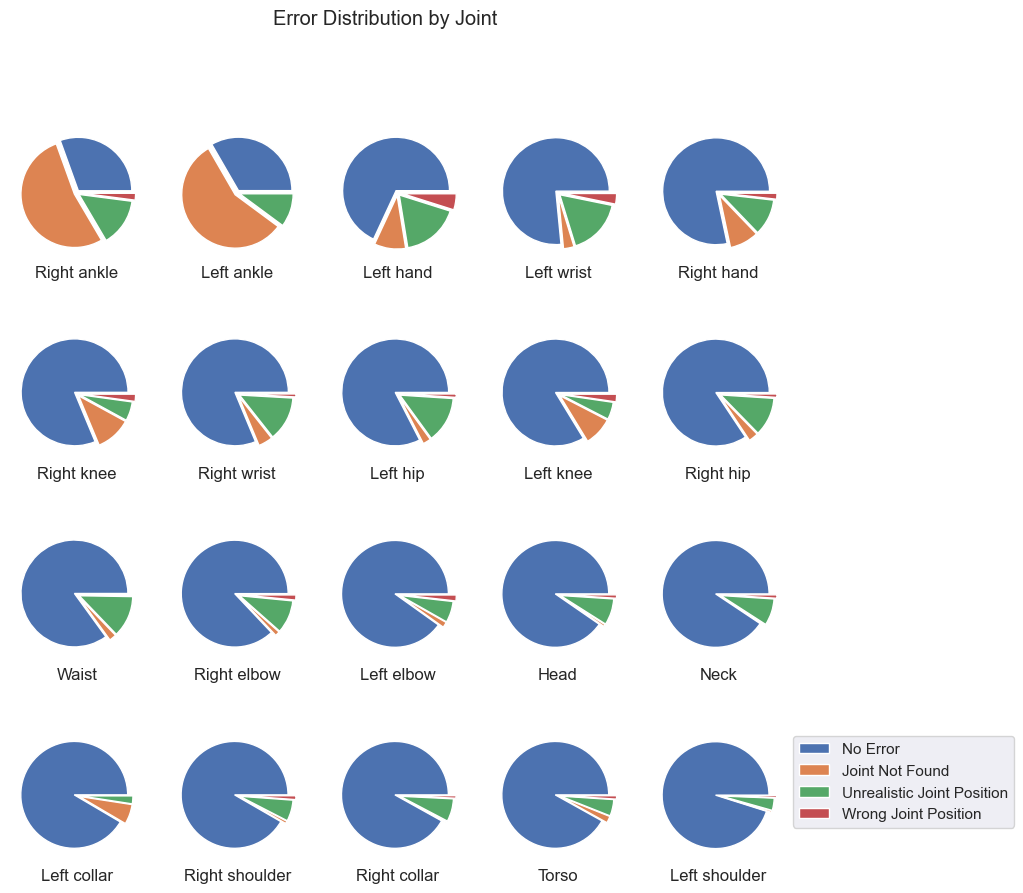

In [225]:
s = df_data_joints[["Joint", "Simple Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = joint_names
s = s.sort_values(by="Simple Error", ascending=False)

err_joints = df_data_joints[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, figsize=(10, 10), layout=(4, 5), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.05,.05,.1))

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(joint_errors, loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Joint")
plt.savefig("figures/dist_joints/Error_Distribution_by_Joint.png")
plt.plot()

#### Full Body

In [226]:
df_data_full_body["Joint Name"] = df_data_full_body["Joint"].apply(lambda x: joint_names[x])
df_data_full_body["Difficulty Name"] = df_data_full_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_full_body

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\2603899009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_full_body["Joint Name"] = df_data_full_body["Joint"].apply(lambda x: joint_names[x])
C:\Users\leona\AppData\Local\Temp\ipykernel_24772\2603899009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_full_body["Difficulty Name"] = df_data_full_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")


,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
0,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0.0,Mode.FULL_BODY,Head,Trivial
29,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,0,0.0,Mode.FULL_BODY,Head,Trivial
58,Train,Session 2023-02-28T22:58:23,0,E-0.00,2,0,0.0,Mode.FULL_BODY,Head,Trivial
87,Train,Session 2023-02-28T22:58:23,0,E-0.00,3,0,0.0,Mode.FULL_BODY,Head,Trivial
116,Train,Session 2023-02-28T22:58:23,0,E-0.00,4,0,0.0,Mode.FULL_BODY,Head,Trivial
...,...,...,...,...,...,...,...,...,...,...
22475,Test,Session 2023-03-01T14:55:16,3,E-3.01,25,0,1.0,Mode.FULL_BODY,Head,Hard
22504,Test,Session 2023-03-01T14:55:16,3,E-3.01,26,0,1.0,Mode.FULL_BODY,Head,Hard
22533,Test,Session 2023-03-01T14:55:16,3,E-3.01,27,0,0.0,Mode.FULL_BODY,Head,Hard
22562,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,0,0.0,Mode.FULL_BODY,Head,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

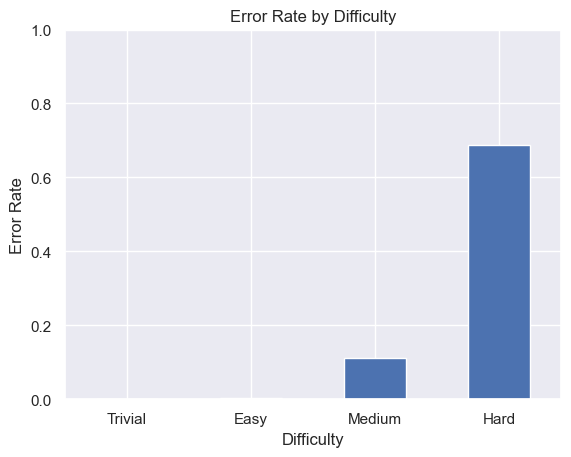

In [228]:
error_by_difficulty = df_data_full_body[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_full_body/Error_Rate_by_Difficulty.png")
ax

#### Body Halves

In [240]:
df_data_half_body["Joint Name"] = df_data_half_body["Joint"].apply(lambda x: body_halves[x])
df_data_half_body["Difficulty Name"] = df_data_half_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
#df_data_half_body["Error"] = df_data_half_body[["Joint Name", "Error"]].apply(lambda x: x["Joint Name"] if x["Error"] == 1 else "No Error", axis=1)
df_data_half_body

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\117277625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_half_body["Joint Name"] = df_data_half_body["Joint"].apply(lambda x: body_halves[x])
C:\Users\leona\AppData\Local\Temp\ipykernel_24772\117277625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_half_body["Difficulty Name"] = df_data_half_body["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")


,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
1,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0,Mode.HALF_BODY,Upper Half,Trivial
2,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0,Mode.HALF_BODY,Lower Half,Trivial
30,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,0,0,Mode.HALF_BODY,Upper Half,Trivial
31,Train,Session 2023-02-28T22:58:23,0,E-0.00,1,1,0,Mode.HALF_BODY,Lower Half,Trivial
59,Train,Session 2023-02-28T22:58:23,0,E-0.00,2,0,0,Mode.HALF_BODY,Upper Half,Trivial
...,...,...,...,...,...,...,...,...,...,...
22535,Test,Session 2023-03-01T14:55:16,3,E-3.01,27,1,0,Mode.HALF_BODY,Lower Half,Hard
22563,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,0,0,Mode.HALF_BODY,Upper Half,Hard
22564,Test,Session 2023-03-01T14:55:16,3,E-3.01,28,1,0,Mode.HALF_BODY,Lower Half,Hard
22592,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,0,0,Mode.HALF_BODY,Upper Half,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

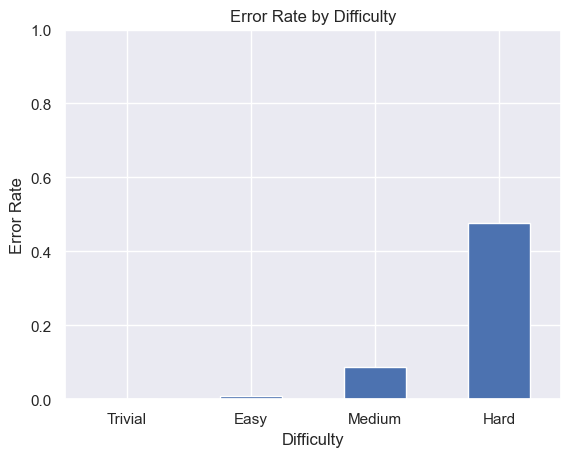

In [253]:
error_by_difficulty = df_data_half_body[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_half_body/Error_Rate_by_Difficulty.png")
ax

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\2147437228.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 2), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.25)


[]

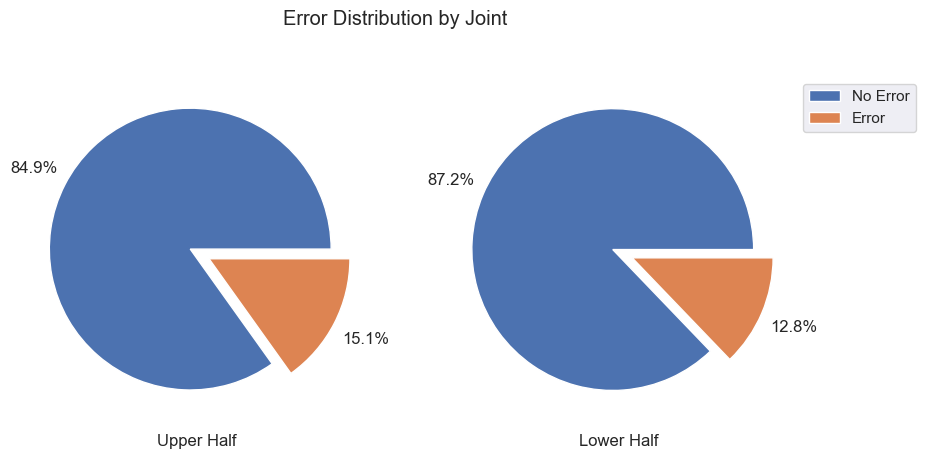

In [261]:
s = df_data_half_body[["Joint", "Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = body_halves
s = s.sort_values(by="Error", ascending=False)

err_joints = df_data_half_body[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(1, 2), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.25)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Joint")
plt.savefig("figures/dist_half_body/Error_Distribution_by_Joint.png")
plt.plot()

#### Limbs

In [251]:
df_data_limbs["Joint Name"] = df_data_limbs["Joint"].apply(lambda x: limbs[x])
df_data_limbs["Difficulty Name"] = df_data_limbs["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")
df_data_limbs

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\2635984076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_limbs["Joint Name"] = df_data_limbs["Joint"].apply(lambda x: limbs[x])
C:\Users\leona\AppData\Local\Temp\ipykernel_24772\2635984076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_limbs["Difficulty Name"] = df_data_limbs["Difficulty"].apply(lambda x: "Trivial" if x == 0 else "Easy" if x == 1 else "Medium" if x == 2 else "Hard")


,Type,Session,Difficulty,Exercise,Frame,Joint,Error,mode,Joint Name,Difficulty Name
3,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,0,0.0,Mode.LIMBS,Head,Trivial
4,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,1,0.0,Mode.LIMBS,Torso,Trivial
5,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,2,0.0,Mode.LIMBS,Left arm,Trivial
6,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,3,0.0,Mode.LIMBS,Right arm,Trivial
7,Train,Session 2023-02-28T22:58:23,0,E-0.00,0,4,0.0,Mode.LIMBS,Left leg,Trivial
...,...,...,...,...,...,...,...,...,...,...
22595,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,1,0.0,Mode.LIMBS,Torso,Hard
22596,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,2,0.0,Mode.LIMBS,Left arm,Hard
22597,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,3,0.0,Mode.LIMBS,Right arm,Hard
22598,Test,Session 2023-03-01T14:55:16,3,E-3.01,29,4,0.0,Mode.LIMBS,Left leg,Hard


<Axes: title={'center': 'Error Rate by Difficulty'}, xlabel='Difficulty', ylabel='Error Rate'>

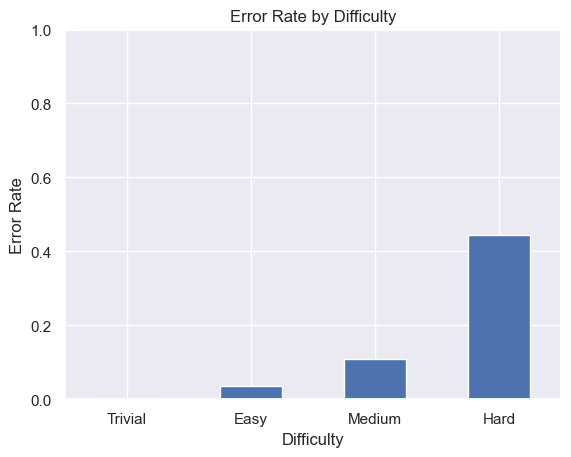

In [254]:
error_by_difficulty = df_data_limbs[['Difficulty', "Difficulty Name", "Error"]].groupby(["Difficulty Name"]).mean().sort_values(by="Difficulty")["Error"]
ax = error_by_difficulty.plot.bar()
ax.set_ylabel("Error Rate")
ax.set_xlabel("Difficulty")
ax.set_title("Error Rate by Difficulty")
ax.set_ylim(0, 1)
labels = ['Trivial', 'Easy', 'Medium', 'Hard']
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(labels, rotation=0, ha='center')
plt.savefig("figures/dist_limbs/Error_Rate_by_Difficulty.png")
ax

C:\Users\leona\AppData\Local\Temp\ipykernel_24772\2800437317.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = edj.plot.pie(ax=ax1, subplots=True, layout=(2, 3), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.35)


[]

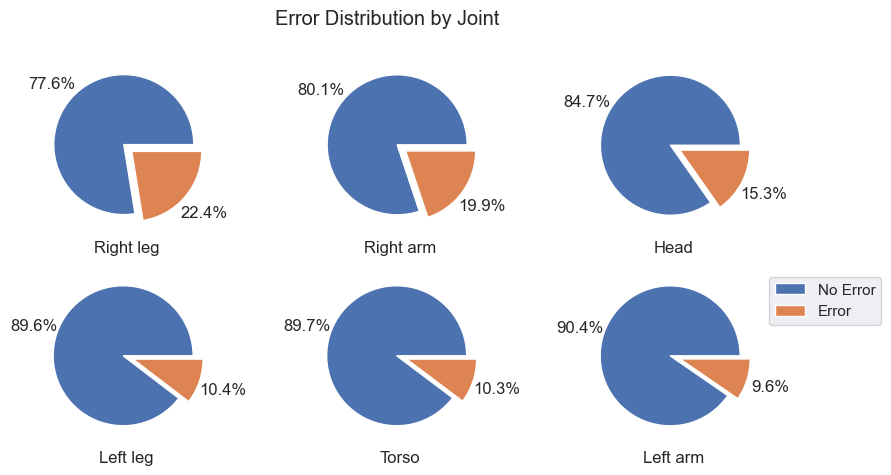

In [260]:
s = df_data_limbs[["Joint", "Error"]].groupby(["Joint"]).sum()
s["Sorted Names"] = limbs
s = s.sort_values(by="Error", ascending=False)

err_joints = df_data_limbs[["Joint", "Joint Name", "Error"]]
error_distribution_by_joint = err_joints.groupby(["Joint", "Error"]).count().unstack().reindex(s.index).T

error_distribution_by_joint = (error_distribution_by_joint / error_distribution_by_joint.sum()).T.fillna(0)
error_distribution_by_joint.columns = error_distribution_by_joint.columns.droplevel()

error_distribution_by_joint.index = s["Sorted Names"].tolist()

edj = error_distribution_by_joint.T

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)

axs = edj.plot.pie(ax=ax1, subplots=True, layout=(2, 3), legend=False, title="Error Distribution by Joint", fontsize=12, sharex=False, sharey=False, labeldistance=None, explode=(.05,.1), autopct='%1.1f%%', pctdistance=1.35)

for ax in axs.flatten():
  ax.set_xlabel(ax.get_ylabel())
  ax.set_ylabel("")

plt.legend(["No Error", "Error"], loc='upper left', bbox_to_anchor=(1, 1))

ax1.set_title("Error Distribution by Joint")
plt.savefig("figures/dist_limbs/Error_Distribution_by_Joint.png")
plt.plot()

## Model

Build the model according to the chosen mode

In [8]:
all_modes = True
mode = Mode.FULL_BODY

if all_modes:
  model_full_body = nn.DataParallel(FESD(Mode.FULL_BODY.get_num_layers()))
  model_half_body = nn.DataParallel(FESD(Mode.HALF_BODY.get_num_layers()))
  model_limbs     = nn.DataParallel(FESD(Mode.LIMBS.get_num_layers()))
  model_joints    = nn.DataParallel(FESD(Mode.JOINTS.get_num_layers()))
else:
  model = nn.DataParallel(FESD(mode.get_num_layers()))

if is_cuda:
  if all_modes:
    model_full_body = model_full_body.cuda()
    model_half_body = model_half_body.cuda()
    model_limbs     = model_limbs.cuda()
    model_joints    = model_joints.cuda()
  else:
    model = model.cuda()

### Train Model

In the following we define the training function and train a network on the training data.

In [42]:
if (all_modes):
  train_loader_full_body  = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.FULL_BODY), batch_size=batchsize)
  test_loader_full_body   = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.FULL_BODY, test=True))
  train_loader_half_body  = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.HALF_BODY), batch_size=batchsize)
  test_loader_half_body   = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.HALF_BODY, test=True))
  train_loader_limbs      = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.LIMBS), batch_size=batchsize)
  test_loader_limbs       = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.LIMBS, test=True))
  train_loader_joints     = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.JOINTS), batch_size=batchsize)
  test_loader_joints      = torch.utils.data.DataLoader(FESDDataset(RECORDING_DIR, train_size, mode=Mode.JOINTS, test=True))

else:
  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
  test_loader = torch.utils.data.DataLoader(dataset_test)

Recordings Found: 17
Total Frames: 510
Mode.FULL_BODY
Recordings Found: 9
Total Frames: 270
Mode.FULL_BODY
Recordings Found: 17
Total Frames: 510
Mode.HALF_BODY
Recordings Found: 9
Total Frames: 270
Mode.HALF_BODY
Recordings Found: 17
Total Frames: 510
Mode.LIMBS
Recordings Found: 9
Total Frames: 270
Mode.LIMBS
Recordings Found: 17
Total Frames: 510
Mode.JOINTS
Recordings Found: 9
Total Frames: 270
Mode.JOINTS


In [9]:
# epoch number
epochs = 100
# optimizer
optim = 'adam'
# learning rate
learning_rate = 0.000025
# learning rate scheduler. can be step, poly or cosine
lr_scheduler = 'cosine'
# warmup epoch
warmup_epoch = -1
# warmup multiplier
warmup_multiplier = 100
# for step scheduler. where to decay lr, can be a list
lr_decay_epochs = [120, 160, 200]
# for step scheduler. step size to decay lr
lr_decay_steps = 20 
# for step scheduler. decay rate for learning rate
lr_decay_rate = 0.01
# weight decay
weight_decay = 0.0001
# momentum for SGD
momentum = 0.9
# gradient clipping margin
clip = 0.5

In [27]:
n_data = len(train_loader.dataset)
CE = torch.nn.CrossEntropyLoss()

if mode == Mode.FULL_BODY:
    CE = torch.nn.CrossEntropyLoss()

if is_cuda:
    CE = CE.cuda()

if all_modes:
    if optim == 'adam':
        optimizer_full_body = torch.optim.Adam(model_full_body.parameters(),    learning_rate, weight_decay=weight_decay)
        optimizer_half_body = torch.optim.Adam(model_half_body.parameters(),    learning_rate, weight_decay=weight_decay)
        optimizer_limbs     = torch.optim.Adam(model_limbs.parameters(),        learning_rate, weight_decay=weight_decay)
        optimizer_joints    = torch.optim.Adam(model_joints.parameters(),       learning_rate, weight_decay=weight_decay)
    elif optim == 'adamW':
        optimizer_full_body = torch.optim.AdamW(model_full_body.parameters(),   learning_rate, weight_decay=weight_decay)
        optimizer_half_body = torch.optim.AdamW(model_half_body.parameters(),   learning_rate, weight_decay=weight_decay)
        optimizer_limbs     = torch.optim.AdamW(model_limbs.parameters(),       learning_rate, weight_decay=weight_decay)
        optimizer_joints    = torch.optim.AdamW(model_joints.parameters(),      learning_rate, weight_decay=weight_decay)
    elif optim == 'sdg':
        optimizer_full_body = torch.optim.SGD(model_full_body.parameters(),     learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)
        optimizer_half_body = torch.optim.SGD(model_half_body.parameters(),     learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)
        optimizer_limbs     = torch.optim.SGD(model_limbs.parameters(),         learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)
        optimizer_joints    = torch.optim.SGD(model_joints.parameters(),        learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)

    scheduler_full_body     = get_scheduler(optimizer_full_body, len(train_loader_full_body), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch,     warmup_multiplier)
    scheduler_half_body     = get_scheduler(optimizer_half_body, len(train_loader_half_body), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)
    scheduler_limbs         = get_scheduler(optimizer_limbs, len(train_loader_limbs), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)
    scheduler_joints        = get_scheduler(optimizer_joints, len(train_loader_joints), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)
else:
    if optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
    elif optim == 'adamW':
        optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay=weight_decay)
    elif optim == 'sdg':
        optimizer = torch.optim.SGD(model.parameters(), learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)

    scheduler = get_scheduler(optimizer, len(train_loader), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)


In [44]:
if all_modes:
    model_iterator = list(zip([Mode.FULL_BODY,          Mode.HALF_BODY,         Mode.LIMBS,         Mode.JOINTS], 
                              [model_full_body,         model_half_body,        model_limbs,        model_joints], 
                              [optimizer_full_body,     optimizer_half_body,    optimizer_limbs,    optimizer_joints], 
                              [scheduler_full_body,     scheduler_half_body,    scheduler_limbs,    scheduler_joints],
                              [train_loader_full_body,  train_loader_half_body, train_loader_limbs, train_loader_joints], 
                              [test_loader_full_body,   test_loader_half_body,  test_loader_limbs,  test_loader_joints]))

In [59]:
model_columns = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified", "mode"]
                  
df_model = pd.DataFrame(columns=model_columns)
pb = tqdm(range(1, epochs + 1), desc='Epoch')

for epoch in pb:
    if all_modes:    
        print(f"--- {epoch:3d} ---")
        for mode, model, optimizer, scheduler, train_loader, _ in model_iterator:
            tic = time()
            torch.cuda.empty_cache()
            
            loss = train(train_loader, model, optimizer, CE, scheduler, clip, epoch, epochs, is_cuda, mode, df_model)  
            pb.set_description(f'Epoch (mode: {mode.name.lower().replace("_", " "):>10}, lr: {optimizer.param_groups[0]["lr"]:.3e}, loss: {loss:.3e})')
        
            print(f'Epoch (mode: {mode.name.lower().replace("_", " "):>10}, lr: {optimizer.param_groups[0]["lr"]:.3e}, loss: {loss:.3e})')

            if (epoch) % 10 == 0:
                torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{mode.name.lower()}_{epoch}_ckpt.pth")) 
    else:
        tic = time()
        torch.cuda.empty_cache()
        loss = train(train_loader, model, optimizer, CE, scheduler, clip, epoch, epochs, is_cuda, mode, df_model)

        pb.set_description(f'Epoch (mode: {mode.name.lower().replace("_", " "):>10}, lr: {optimizer.param_groups[0]["lr"]:.3e}, loss: {loss:.3e})')
        
        if (epoch) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{epoch}_ckpt.pth"))
    
if all_modes:
    for mode, model, _, _, _, _ in model_iterator:
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{mode.name.lower()}_last_ckpt.pth")) 
        print(f"model saved {os.path.join(CHECKPOINT_DIR, f'last_ckpt.pth')}!")
else:
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth"))
    print(f"model saved {os.path.join(CHECKPOINT_DIR, f'last_ckpt.pth')}!")
    checkpoint = os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth")

df_model.to_csv("ModelAnalysis.csv")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

---   1 ---
Epoch (mode:  full body, lr: 2.482e-05, loss: -4.225e+07)
Epoch (mode:  half body, lr: 2.482e-05, loss: -1.784e+05)
Epoch (mode:      limbs, lr: 2.479e-05, loss: -4.962e+05)
Epoch (mode:     joints, lr: 2.494e-05, loss: -1.816e+05)
---   2 ---
Epoch (mode:  full body, lr: 2.475e-05, loss: -5.354e+07)
Epoch (mode:  half body, lr: 2.475e-05, loss: -3.907e+05)
Epoch (mode:      limbs, lr: 2.472e-05, loss: -1.040e+06)
Epoch (mode:     joints, lr: 2.489e-05, loss: -6.992e+05)
---   3 ---
Epoch (mode:  full body, lr: 2.467e-05, loss: -6.830e+07)
Epoch (mode:  half body, lr: 2.467e-05, loss: -7.582e+05)
Epoch (mode:      limbs, lr: 2.463e-05, loss: -1.972e+06)
Epoch (mode:     joints, lr: 2.484e-05, loss: -2.045e+06)
---   4 ---
Epoch (mode:  full body, lr: 2.457e-05, loss: -8.450e+07)
Epoch (mode:  half body, lr: 2.458e-05, loss: -1.347e+06)
Epoch (mode:      limbs, lr: 2.453e-05, loss: -3.502e+06)
Epoch (mode:     joints, lr: 2.477e-05, loss: -5.015e+06)
---   5 ---
Epoch (mode:

ValueError: too many values to unpack (expected 4)

In [62]:
df_model.to_csv("ModelAnalysis.csv")

In [ ]:
input_names = ["RGB", "Depth", "Joints"]
output_names = ["Errors"]

torch.onnx.export(model, (rgb, depth, pose_2d), 'FESD.onnx', input_names=input_names, output_names=output_names)

### Test Model

In [64]:
if all_modes:
  for mode, model, _, _, _, test_loader in model_iterator:
    test(test_loader, model, CE, is_cuda, mode, df_model)
else: 
  test(test_loader, model, CE, is_cuda, mode, df_model)

In [65]:
df_model.to_csv("ModelAnalysis.csv")

In [68]:
df_model.to_parquet('ModelAnalysis.parquet.gzip', compression='gzip') 

ArrowInvalid: ('Could not convert <Mode.FULL_BODY: 0> with type Mode: did not recognize Python value type when inferring an Arrow data type', 'Conversion failed for column mode with type object')

### Model Evaluation

Here we create all graphs and analysis for the training

In [6]:
df_model = pd.read_csv("ModelAnalysis.csv").drop('Unnamed: 0', axis=1)
df_model.head()

,epoch,iteration,joint_id,gts,preds,confidences,Avg loss,loss,accuracy,tp,...,fp,fn,precision,recall,f1,cohens_kappa,learning_rate,train_test,exercise,simplified
0,1,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 3.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.2,2.0,...,8.0,8.0,0.2,0.2,0.1,NaN,0.000025,train,E-0.00,False
1,1,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.2,2.0,...,0.0,8.0,0.2,0.2,0.2,0.0,0.000025,train,E-0.00,True
2,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 0.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.6,6.0,...,4.0,4.0,0.6,0.6,0.3,NaN,0.000025,train,E-0.00,False
3,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.6,6.0,...,0.0,4.0,0.6,0.6,0.6,0.0,0.000025,train,E-0.00,True
4,1,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.6,6.0,...,4.0,4.0,0.6,0.6,0.3,NaN,0.000025,train,E-0.00,False


In [19]:
df_model["joint_name"] = df_model.apply(lambda x: joint_names[x["joint_id"]], axis=1)
df_model["difficulty"] = df_model.apply(lambda x: int(x["exercise"][2]), axis=1)

C:\Users\leona\AppData\Local\Temp\ipykernel_24624\3118677857.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_model.groupby(["epoch", "difficulty"]).mean()["accuracy"].plot()


<Axes: xlabel='epoch,difficulty'>

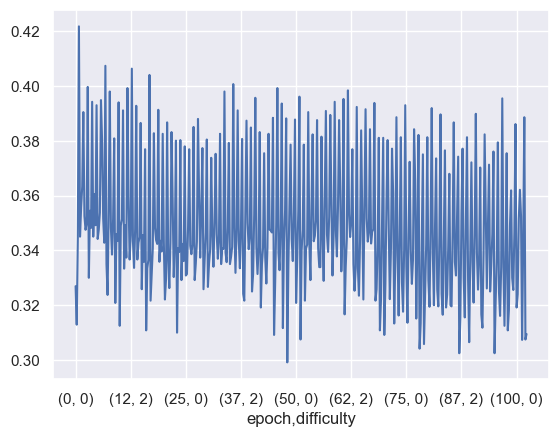

In [21]:
df_model.groupby(["epoch", "difficulty"]).mean()["accuracy"].plot()

In [14]:
df_train = df_model[df_model['train_test'] == 'train']
df_test = df_model[df_model['train_test'] == 'test']
df_train.head()

,epoch,iteration,joint_id,gts,preds,confidences,Avg loss,loss,accuracy,tp,...,fn,precision,recall,f1,cohens_kappa,learning_rate,train_test,exercise,simplified,joint_name
0,1,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 3.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.2,2.0,...,8.0,0.2,0.2,0.1,NaN,0.000025,train,E-0.00,False,Head
1,1,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.2,2.0,...,8.0,0.2,0.2,0.2,0.0,0.000025,train,E-0.00,True,Head
2,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 0.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.6,6.0,...,4.0,0.6,0.6,0.3,NaN,0.000025,train,E-0.00,False,Neck
3,1,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.6,6.0,...,4.0,0.6,0.6,0.6,0.0,0.000025,train,E-0.00,True,Neck
4,1,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-24653906.0,-24653906.0,0.6,6.0,...,4.0,0.6,0.6,0.3,NaN,0.000025,train,E-0.00,False,Torso


<Axes: xlabel='epoch'>

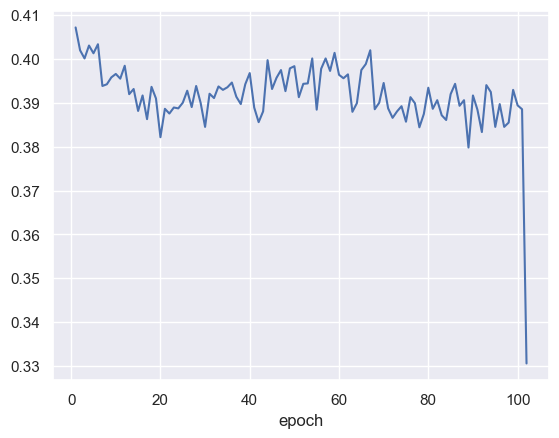

In [15]:
df_train[df_train["simplified"] == True].groupby("epoch").mean(numeric_only=True)["accuracy"].plot()

In [22]:
df_test[df_test['simplified'] == True].groupby(["epoch", "joint_name"]).sum().sort_values("accuracy", ascending=False)

C:\Users\leona\AppData\Local\Temp\ipykernel_24624\3404869017.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test[df_test['simplified'] == True].groupby(["epoch", "joint_name"]).sum().sort_values("accuracy", ascending=False)


iteration  joint_id      Avg loss          loss  \
epoch joint_name                                                        
0     Left elbow          36585      1620 -2.687757e+14 -2.675656e+14   
      Waist               36585       810 -2.687757e+14 -2.675656e+14   
      Right hand          36585      3510 -2.687757e+14 -2.675656e+14   
      Right ankle         36585      5130 -2.687757e+14 -2.675656e+14   
      Left ankle          36585      4320 -2.687757e+14 -2.675656e+14   
      Left wrist          36585      1890 -2.687757e+14 -2.675656e+14   
      Left hand           36585      2160 -2.687757e+14 -2.675656e+14   
      Neck                36585       270 -2.687757e+14 -2.675656e+14   
      Right collar        36585      2430 -2.687757e+14 -2.675656e+14   
      Right knee          36585      4860 -2.687757e+14 -2.675656e+14   
      Torso               36585       540 -2.687757e+14 -2.675656e+14   
      Left hip            36585      3780 -2.687757e+14 -2.675656e+14   
      Head                36585         0 -2.687757e+14 -2.675656e+14   
      Right hip           36585      4590 -2.687757e+14 -2.675656e+14   
      Left shoulder       36585      1350 -2.687757e+14 -2.675656e+14   
      Left collar         36585      1080 -2.687757e+14 -2.675656e+14   
      Right wrist         36585      3240 -2.687757e+14 -2.675656e+14   
      Right elbow         36585      2970 -2.687757e+14 -2.675656e+14   
      Left knee           36585      4050 -2.687757e+14 -2.675656e+14   
      Right shoulder      36585      2700 -2.687757e+14 -2.675656e+14   

                      accuracy     tp     tn    fp     fn  precision  recall  \
epoch joint_name                                                               
0     Left elbow         206.0  204.0    2.0   9.0   55.0      206.0   206.0   
      Waist              189.0  187.0    2.0  43.0   38.0      189.0   189.0   
      Right hand         181.0  169.0   12.0  37.0   52.0      181.0   181.0   
      Right ankle        173.0   29.0  144.0  41.0   56.0      173.0   173.0   
      Left ankle         150.0   10.0  140.0  23.0   97.0      150.0   150.0   
      Left wrist         125.0   87.0   38.0  28.0  117.0      125.0   125.0   
      Left hand          123.0   54.0   69.0  31.0  116.0      123.0   123.0   
      Neck               118.0   96.0   22.0  16.0  136.0      118.0   118.0   
      Right collar       115.0  101.0   14.0  17.0  138.0      115.0   115.0   
      Right knee         114.0   93.0   21.0   5.0  151.0      114.0   114.0   
      Torso              113.0   91.0   22.0   7.0  150.0      113.0   113.0   
      Left hip            94.0   56.0   38.0   9.0  167.0       94.0    94.0   
      Head                92.0   66.0   26.0   7.0  171.0       92.0    92.0   
      Right hip           59.0   18.0   41.0   3.0  208.0       59.0    59.0   
      Left shoulder       51.0   43.0    8.0   2.0  217.0       51.0    51.0   
      Left collar         49.0   23.0   26.0   6.0  215.0       49.0    49.0   
      Right wrist         45.0    8.0   37.0   2.0  223.0       45.0    45.0   
      Right elbow         43.0    2.0   41.0   0.0  227.0       43.0    43.0   
      Left knee           42.0   15.0   27.0   5.0  223.0       42.0    42.0   
      Right shoulder      36.0    6.0   30.0   2.0  232.0       36.0    36.0   

                         f1  cohens_kappa  learning_rate  simplified  
epoch joint_name                                                      
0     Left elbow      206.0           0.0            0.0         270  
      Waist           189.0           0.0            0.0         270  
      Right hand      181.0           0.0            0.0         270  
      Right ankle     173.0           0.0            0.0         270  
      Left ankle      150.0           0.0            0.0         270  
      Left wrist      125.0           0.0            0.0         270  
      Left hand       123.0           0.0            0.0         270  
      Neck     

In [ ]:
loss = 0
for j in range(0, 20):
  print(gt, pred)
  loss += CE(gt[:,j], pred[:,j])
loss

tensor(635.1016, dtype=torch.float64)

In [ ]:
#np.array(gts[0])
gts[0]
gt = torch.tensor(np.array(json.loads(gts[5])))
pred = torch.tensor(np.array(json.loads(preds[5])))


In [ ]:
len(gts) * 20

102000

In [ ]:
df_train_test_cp = df_train_test.copy()

In [ ]:
gts = np.array(df_train[df_train['simplified'] == False]["gts"].tolist())
preds = np.array(df_train[df_train['simplified'] == False]["preds"].tolist())
exercises = np.array(df_train[df_train['simplified'] == False]["exercise"].tolist())

model_columns_test = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified"]

df_train_test = pd.DataFrame(columns=model_columns_test)

for it, (gt, pred, exercise) in tqdm(enumerate(zip(gts, preds, exercises)), total=len(gts)):
  i = it % len(train_loader)
  epoch = it // len(train_loader)

  gt = torch.tensor(np.array(json.loads(gt)))
  pred = torch.tensor(np.array(json.loads(pred)))
  
  loss = 0

  for j in range(0, 20):
    loss += CE(gt[:,j], pred[:,j])

  loss_record = AvgMeter()

  loss_record.update(loss.data, 1)

  val(pred, gt, loss_record, loss, np.NaN, epoch, epochs, i, len(train_loader), "train",  exercise, df_train_test)  

 91%|█████████▏| 4666/5100 [2:20:09<18:55,  2.62s/it]     

In [ ]:
gts = np.array(df_test[df_test['simplified'] == False]["gts"].tolist())
preds = np.array(df_test[df_test['simplified'] == False]["preds"].tolist())
exercises = np.array(df_test[df_test['simplified'] == False]["exercise"].tolist())

model_columns_test = ["epoch", "iteration", "joint_id",
                  "gts", "preds", "confidences", 
                  "Avg loss", "loss", "accuracy", 
                  "tp", "tn", "fp", "fn", "precision", "recall", "f1", 
                  "cohens_kappa", "learning_rate",
                  "train_test", "exercise", "simplified"]

df_test_test = pd.DataFrame(columns=model_columns_test)

for it, (gt, pred, exercise) in tqdm(enumerate(zip(gts, preds, exercises)), total=len(gts)):
  i = it % len(train_loader)
  epoch = it // len(train_loader)

  gt = torch.tensor(np.array(json.loads(gt)))
  pred = torch.tensor(np.array(json.loads(pred)))
  
  loss = 0

  for j in range(0, 20):
    loss += CE(gt[:,j], pred[:,j])

  loss_record = AvgMeter()

  loss_record.update(loss.data, 1)

  val(pred, gt, loss_record, loss, np.NaN, epoch, epochs, i, len(train_loader), "test",  exercise, df_test_test)  

100%|██████████| 270/270 [01:41<00:00,  2.65it/s]


In [ ]:
gt[:,0]

tensor([0.], dtype=torch.float64)

In [ ]:
df_test_test["joint_name"] = df_test_test.apply(lambda x: joint_names[x["joint_id"]], axis=1)

In [ ]:
df_test_test[df_test_test["exercise"] == "E-1.01"][df_test_test["simplified"] == True].reset_index()

C:\Users\leona\AppData\Local\Temp\ipykernel_15996\71018840.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_test[df_test_test["exercise"] == "E-1.01"][df_test_test["simplified"] == True].reset_index()


,index,epoch,iteration,joint_id,gts,preds,confidences,Avg loss,loss,accuracy,...,fn,precision,recall,f1,cohens_kappa,learning_rate,train_test,exercise,simplified,joint_name
0,3601,1,39,0,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Head
1,3603,1,39,1,[0.0],[0.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Neck
2,3605,1,39,2,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Torso
3,3607,1,39,3,[0.0],[0.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Waist
4,3609,1,39,4,[0.0],[0.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Left collar
5,3611,1,39,5,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Left shoulder
6,3613,1,39,6,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Left elbow
7,3615,1,39,7,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Left wrist
8,3617,1,39,8,[1.0],[1.0],NaN,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaN,NaN,test,E-1.01,True,Left hand
9,3619,1,39,9,[0.0],[1.0],NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,NaN,0.0,NaN,test,E-1.01,True,Right collar


In [ ]:
38*20

760

In [ ]:
tps = df_test_test[df_test_test["simplified"] == True].groupby(["exercise"]).sum(numeric_only=True)[["tp", "tn", "fp", "fn", "accuracy"]]
tps["positives"] = tps["tp"] + tps["fn"]
tps["negatives"] = tps["tn"] + tps["fp"]
tps["accuracy"] = tps["accuracy"] / (tps["positives"] + tps["negatives"])
tps.sort_values('accuracy', ascending= False).sort_index(level='exercise', sort_remaining=False)
pd.set_option('display.max_rows', None)
tps = tps.sort_values('accuracy', ascending= False).sort_index(level='exercise', sort_remaining=False)
tps

,tp,tn,fp,fn,accuracy,positives,negatives
exercise,,,,,,,
E-0.01,583.0,67.0,35.0,1115.0,0.361111,1698.0,102.0
E-1.01,403.0,46.0,13.0,738.0,0.374167,1141.0,59.0
E-2.01,336.0,151.0,64.0,649.0,0.405833,985.0,215.0
E-3.01,183.0,440.0,237.0,340.0,0.519167,523.0,677.0


NameError: name 'tps' is not defined

In [ ]:
df_train_test[df_train_test["simplified"] == True][df_train_test["train_test"] == 'train'].groupby(["joint_id"]).mean()

C:\Users\leona\AppData\Local\Temp\ipykernel_15996\2761635824.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_test[df_train_test["simplified"] == True][df_train_test["train_test"] == 'train'].groupby(["joint_id"]).mean()
C:\Users\leona\AppData\Local\Temp\ipykernel_15996\2761635824.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_test[df_train_test["simplified"] == True][df_train_test["train_test"] == 'train'].groupby(["joint_id"]).mean()


,epoch,iteration,confidences,Avg loss,loss,accuracy,tp,tn,fp,fn,precision,recall,f1,cohens_kappa,learning_rate,simplified
joint_id,,,,,,,,,,,,,,,,
0,14.807816,24.801409,NaN,604.237155,604.237155,0.612428,5.836003,0.288277,0.520820,3.354901,0.612428,0.612428,0.612428,-0.006229,NaN,1.0
1,14.807816,24.801409,NaN,604.237155,604.237155,0.442921,4.068546,0.360666,0.312620,5.258168,0.442921,0.442921,0.444916,-0.002501,NaN,1.0
2,14.807816,24.801409,NaN,604.237155,604.237155,0.192633,1.358104,0.568225,0.085842,7.987828,0.192633,0.192633,0.236028,0.002650,NaN,1.0
3,14.807816,24.801409,NaN,604.237155,604.237155,0.829084,8.237028,0.053812,1.330557,0.378603,0.829084,0.829084,0.829615,0.000140,NaN,1.0
4,14.807816,24.801409,NaN,604.237155,604.237155,0.795131,7.839206,0.112108,0.541960,1.506726,0.795131,0.795131,0.795131,0.002769,NaN,1.0
5,14.807816,24.801409,NaN,604.237155,604.237155,0.209865,1.659193,0.439462,0.099295,7.802050,0.209865,0.209865,0.245026,-0.001829,NaN,1.0
6,14.807816,24.801409,NaN,604.237155,604.237155,0.246252,1.360666,1.101858,0.178732,7.358744,0.246252,0.246252,0.302201,0.004619,NaN,1.0
7,14.807816,24.801409,NaN,604.237155,604.237155,0.353748,1.800769,1.736707,0.536195,5.926329,0.353748,0.353748,0.370107,-0.002968,NaN,1.0
8,14.807816,24.801409,NaN,604.237155,604.237155,0.303203,0.249840,2.782191,0.117233,6.850737,0.303203,0.303203,0.406965,-0.000737,NaN,1.0
